In [ ]:
# BETO installation

!pip install transformers
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/pytorch_weights.tar.gz 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/vocab.txt 
!wget https://users.dcc.uchile.cl/~jperez/beto/cased_2M/config.json 
!tar -xzvf pytorch_weights.tar.gz
!mv config.json pytorch/.
!mv vocab.txt pytorch/.

In [18]:
#for cleaning:
!pip install langdetect

In [19]:
import torch
from transformers import BertForMaskedLM, BertTokenizer

In [20]:
from google.cloud import bigquery
from langdetect import detect
from google.colab import auth,drive
import pandas as pd

In [21]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [22]:
auth.authenticate_user()

In [23]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [24]:
# sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)
# dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [25]:
# deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

cat_count = df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category

In [26]:
# 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)
# organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [27]:
# creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description,is_valid
0,anthropology,"""Después de 60 años como misionero en el Perú ...",False
1,anthropology,A lo largo de los últimos cien años la antropo...,False
2,anthropology,"En este libro, uno de los principales teoricos...",False
3,anthropology,"El fuego, presente ya en los inicios del proce...",False
4,anthropology,Este ambicioso tratado sobre el fenómeno relig...,False


In [28]:
# creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description,is_valid
85,anthropology,Antología preparada en torno al axolote (o axó...,True
86,anthropology,Sirviéndose de los recursos metodológicos prop...,True
87,anthropology,Este trabajo consta de dos partes bien diferen...,True
88,anthropology,"Los problemas de la bioética no solo son, en l...",True
89,anthropology,"La ANTROPOLOGÍA kantiana, más que en la divers...",True


In [29]:
dff = pd.concat([train_set_f, val_set_f]).reset_index(drop=True)

In [ ]:
# create the tokenizer and the model

tokenizer = BertTokenizer.from_pretrained("pytorch/", do_lower_case=False)
model = BertForMaskedLM.from_pretrained("pytorch/")
#model.eval()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f83af09d0b8>]],
      dtype=object)

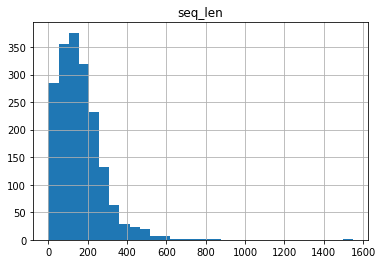

In [53]:
#having a look at the distribution of the sequence lengths(# of words) in the train set to find the right padding length

seq_len = pd.DataFrame([len(i.split()) for i in train_set_f['description']],columns=['seq_len'])

seq_len.hist(bins = 30)

In [155]:
def intervals():
  to_return=list()
  j=0
  for i in range(0,32):
    to_return.append(j)
    j+=50

  return to_return
    
ranges = intervals()

sl_grouped=seq_len.groupby(pd.cut(seq_len.seq_len, ranges)).count().rename(columns={'seq_len':''})
sl_grouped=sl_grouped.add_suffix('count').reset_index()
sl_grouped['%']=round(100*sl_grouped['count'].cumsum()/sl_grouped['count'].sum(),3)

In [161]:
sl_grouped.iloc[0:10,:] 

,seq_len,count,%
0,"(0, 50]",267,14.363
1,"(50, 100]",351,33.244
2,"(100, 150]",359,52.555
3,"(150, 200]",315,69.500
4,"(200, 250]",244,82.625
5,"(250, 300]",148,90.586
6,"(300, 350]",67,94.190
7,"(350, 400]",36,96.127
8,"(400, 450]",24,97.418
9,"(450, 500]",24,98.709
